## Transformer

This is a re-implementation of the transformer (mostly copied) with some comments for explaining all the concepts of *the future of ML*. Even CNNs are being outperformed by transformers now. Times are changing, all hail the transformer.

Primary resource:
- http://nlp.seas.harvard.edu/2018/04/03/attention.html#positional-encoding

Other references:
- https://towardsdatascience.com/how-to-code-the-transformer-in-pytorch-24db27c8f9ec
- http://jalammar.github.io/illustrated-transformer/

In [1]:
# Imports

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import pandas as pd
import torch
import copy
import math
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

In [2]:
# Setup PyTorch

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [51]:
# EncoderDecoder structure

# The Transformer is fundamentally an encoder decoder structure with self-attention layers
class EncoderDecoder(nn.Module):
    """
    A standard Encoder-Decoder architecture. Base for this and many 
    other models.
    """
    def __init__(self, encoder, decoder, src_embed, tgt_embed, generator):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder # Encoder stack we create later
        self.decoder = decoder # Decoder stack we create later
        self.src_embed = src_embed # Embedding network to go from token to vector
        self.tgt_embed = tgt_embed # Embedding network to go from token to vector
        self.generator = generator
        
    def forward(self, src, tgt, src_mask, tgt_mask):
        "Take in and process masked src and target sequences."
        return self.decode(self.encode(src, src_mask), src_mask, tgt, tgt_mask) # Output of encoder stack is "memory" for decoder
    
    def encode(self, src, src_mask):
        return self.encoder(self.src_embed(src), src_mask)
    
    def decode(self, memory, src_mask, tgt, tgt_mask):
        return self.decoder(self.tgt_embed(tgt), memory, src_mask, tgt_mask)

# The generator is used to go from output of decoder stack to probabilities of vocabulary
class Generator(nn.Module):
    "Define standard linear + softmax generation step."
    def __init__(self, d_model, vocab):
        super(Generator, self).__init__()
        self.proj = nn.Linear(d_model, vocab)

    def forward(self, x):
        return F.log_softmax(self.proj(x), dim=-1)

In [4]:
# Network building blocks

# Return a ModuleList with the given module repeated N times
def clones(module, N):
    "Produce N identical layers."
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

# LayerNorm module from https://arxiv.org/abs/1607.06450 , helps with training time of network
class LayerNorm(nn.Module):
    "Construct a layernorm module (See citation for details)."
    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2

# Module to simplify sublayer creation. Skip connection is implemented using sublayer and layer normalization and dropout layers are added
class SublayerConnection(nn.Module):
    """
    A residual connection followed by a layer norm.
    Note for code simplicity the norm is first as opposed to last.
    """
    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        "Apply residual connection to any sublayer with the same size."
        return x + self.dropout(sublayer(self.norm(x))) # residual connection by adding input + output of layer

In [5]:
# Encoder

# Main encoder structure, each layer has a set of sublayers (self-attention + fcnn). Layers are cloned and the final output is normalized
class Encoder(nn.Module):
    "Core encoder is a stack of N layers"
    def __init__(self, layer, N):
        super(Encoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
        
    def forward(self, x, mask):
        "Pass the input (and mask) through each layer in turn."
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)

# One complete encoder layer, will get stacked to form complete encoder stack
# Internally, input skip self-attention, self-attention output skip fnn output
class EncoderLayer(nn.Module):
    "Encoder is made up of self-attn and feed forward (defined below)"
    def __init__(self, size, self_attn, feed_forward, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 2)
        self.size = size

    def forward(self, x, mask):
        "Follow Figure 1 (left) for connections."
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask)) # input + output of self_attention
        return self.sublayer[1](x, self.feed_forward) # output of prev + output of feed forward

In [6]:
# Decoder

# Main decoder structure, each layer has a set of sublayers (self-attention + fcnn). Layers are cloned and the final output is normalized
class Decoder(nn.Module):
    "Generic N layer decoder with masking."
    def __init__(self, layer, N):
        super(Decoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
        
    def forward(self, x, memory, src_mask, tgt_mask):
        for layer in self.layers:
            x = layer(x, memory, src_mask, tgt_mask)
        return self.norm(x)

# One complete decoder layer, will get stacked to form complete decoder stack
# Main difference from encoder layer is multi-head attention over output of encoder stack
# Specifically, creates queries matrix from previous block and uses key and values from encoder stack (memory)
class DecoderLayer(nn.Module):
    "Decoder is made of self-attn, src-attn, and feed forward (defined below)"
    def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
        super(DecoderLayer, self).__init__()
        self.size = size
        self.self_attn = self_attn
        self.src_attn = src_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 3)
 
    def forward(self, x, memory, src_mask, tgt_mask):
        "Follow Figure 1 (right) for connections."
        m = memory
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, tgt_mask))
        x = self.sublayer[1](x, lambda x: self.src_attn(x, m, m, src_mask))
        return self.sublayer[2](x, self.feed_forward)

# Function to generate mask so decoder attention can only look at previous words
# 1 0 0 0 0
# 1 1 0 0 0
# ...
def subsequent_mask(size):
    "Mask out subsequent positions."
    attn_shape = (1, size, size)
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
    return torch.from_numpy(subsequent_mask) == 0

# Attention

Self-attention is calculated via scaled dot product. 

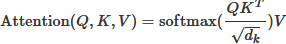

We then use the idea of self-attention and add the concept of multiple heads

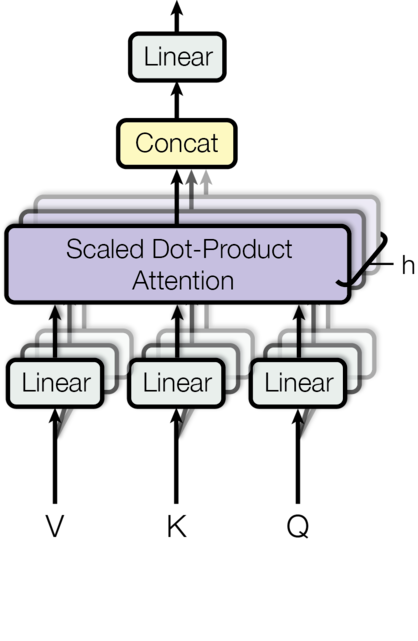

Take each of the Q, K, V vectors and pass it through a linear layer to add some trainable weight matrix to it. All the heads share the same weight matrix (linear layer) but each type of matrix (Q, K, V) get their own. After we get the embedded vectors, we transform it from d_model (originally embedding dimensions), to h x d_k where d_k is just d_model // h. This gives us h "heads". We then apply our attention mechanism to each batch (one "head" is one batch) of the Q, K, V vectors. The attention code is setup to use matrix multiplication to speed up the calculation. We need to convert this to as if the calculations were concatenated using view(). Finally, we pass the concatenated resultant vectors through a final linear layer to get an output of size d_model. This is our final self-attention vector.

## Applications

Directly copied from http://nlp.seas.harvard.edu/2018/04/03/attention.html#positional-encoding

The Transformer uses multi-head attention in three different ways: 1) In “encoder-decoder attention” layers, the queries come from the previous decoder layer, and the memory keys and values come from the output of the encoder. This allows every position in the decoder to attend over all positions in the input sequence. This mimics the typical encoder-decoder attention mechanisms in sequence-to-sequence models such as (cite).

2) The encoder contains self-attention layers. In a self-attention layer all of the keys, values and queries come from the same place, in this case, the output of the previous layer in the encoder. Each position in the encoder can attend to all positions in the previous layer of the encoder.

3) Similarly, self-attention layers in the decoder allow each position in the decoder to attend to all positions in the decoder up to and including that position. We need to prevent leftward information flow in the decoder to preserve the auto-regressive property. We implement this inside of scaled dot- product attention by masking out (setting to −∞
) all values in the input of the softmax which correspond to illegal connections.

In [7]:
# Attention

# Attention calculation via scaled dot product
# Attention(Q,K,V)=softmax(Q * K_transpose / √(d_k) * V)
# Returns output of attention (scaling factor * value) and scaling factor
def attention(query, key, value, mask=None, dropout=None):
    "Compute 'Scaled Dot Product Attention'"
    d_k = query.size(-1)
    scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k)
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9) # if mask is 0, fill slot with -inf
    p_attn = F.softmax(scores, dim = -1)
    if dropout is not None:
        p_attn = dropout(p_attn)
    return torch.matmul(p_attn, value), p_attn

# MutliHeadedAttention module
# Calculates attention for each head then concats and applies a final linear layer
# Important idea is that input query, key, value matrices are all x. The actual matrices are from trained linear layers run on input data
class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        "Take in model size and number of heads."
        super(MultiHeadedAttention, self).__init__()
        assert d_model % h == 0
        # We assume d_v always equals d_k
        self.d_k = d_model // h
        self.h = h
        self.linears = clones(nn.Linear(d_model, d_model), 4)
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, query, key, value, mask=None):
        "Implements Figure 2"
        if mask is not None:
            # Same mask applied to all h heads.
            mask = mask.unsqueeze(1)
        nbatches = query.size(0)
        
        # 1) Do all the linear projections in batch from d_model => h x d_k 
        query, key, value = \
            [l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
             for l, x in zip(self.linears, (query, key, value))]
        
        # 2) Apply attention on all the projected vectors in batch. 
        x, self.attn = attention(query, key, value, mask=mask, dropout=self.dropout)
        
        # 3) "Concat" using a view and apply a final linear. 
        x = x.transpose(1, 2).contiguous().view(nbatches, -1, self.h * self.d_k)
        return self.linears[-1](x)

In [8]:
# FFNN, Embeddings, and PositionalEncoding components

# Simple feed-forward neural network that is applied after attention layers
class PositionwiseFeedForward(nn.Module):
    "Implements FFN equation."
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.w_2(self.dropout(F.relu(self.w_1(x))))

# Embedding network to convert input word to vector
class Embeddings(nn.Module):
    def __init__(self, d_model, vocab):
        super(Embeddings, self).__init__()
        self.lut = nn.Embedding(vocab, d_model)
        self.d_model = d_model

    def forward(self, x):
        return self.lut(x) * math.sqrt(self.d_model)

# Positional encoder to add information about order of word in sequence
# Honestly I'm not completely sure how this works but from the illustrated transformer article it seems like depending on position more or less magnitude is placed on later values
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout, max_seq_len = 80):
        super().__init__()
        self.d_model = d_model
        self.dropout = nn.Dropout(p=dropout)
        
        # create constant 'pe' matrix with values dependant on 
        # pos and i
        pe = torch.zeros((max_seq_len, d_model))
        for pos in range(max_seq_len):
            for i in range(0, d_model, 2):
                pe[pos, i] = math.sin(pos / (10000 ** ((2 * i)/d_model)))
                pe[pos, i + 1] = math.cos(pos / (10000 ** ((2 * (i + 1))/d_model)))
                
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
    
    def forward(self, x):
        # make embeddings relatively larger
        x = x * math.sqrt(self.d_model)
        #add constant to embedding
        seq_len = x.size(1)
        x = x + Variable(self.pe[:,:seq_len], requires_grad=False).to(device)
        return self.dropout(x)

In [9]:
# Function to create full transformer model

def make_model(src_vocab, tgt_vocab, N=6, 
               d_model=512, d_ff=2048, h=8, dropout=0.1):
    "Helper: Construct a model from hyperparameters."
    c = copy.deepcopy
    attn = MultiHeadedAttention(h, d_model)
    ff = PositionwiseFeedForward(d_model, d_ff, dropout)
    position = PositionalEncoding(d_model, dropout)
    model = EncoderDecoder(
        Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),
        Decoder(DecoderLayer(d_model, c(attn), c(attn), 
                             c(ff), dropout), N),
        nn.Sequential(Embeddings(d_model, src_vocab), c(position)),
        nn.Sequential(Embeddings(d_model, tgt_vocab), c(position)),
        Generator(d_model, tgt_vocab))
    
    # This was important from their code. 
    # Initialize parameters with Glorot / fan_avg.
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)
    return model

In [10]:
# Mask generation utility for decoder side

def make_std_mask(tgt, pad):
    "Create a mask to hide padding and future words."
    tgt_mask = (tgt != pad).unsqueeze(-2)
    tgt_mask = tgt_mask & Variable(
        subsequent_mask(tgt.size(-1)).type_as(tgt_mask.data))
    return tgt_mask

In [12]:
# Batch class to hold training data in batches as well as create mask for decoder

class Batch:
    "Object for holding a batch of data with mask during training."
    def __init__(self, src, trg=None, pad=0):
        self.src = src
        self.src_mask = (src != pad).unsqueeze(-2).to(device)
        if trg is not None:
            self.trg = trg[:, :-1].to(device) # cut out last token
            self.trg_y = trg[:, 1:].to(device) # shift trg right by one
            self.trg_mask = self.make_std_mask(self.trg, pad).to(device)
            self.ntokens = (self.trg_y != pad).data.sum().to(device)
    
    @staticmethod
    def make_std_mask(tgt, pad):
        "Create a mask to hide padding and future words."
        tgt_mask = (tgt != pad).unsqueeze(-2)
        tgt_mask = tgt_mask & Variable(
            subsequent_mask(tgt.size(-1)).type_as(tgt_mask.data))
        return tgt_mask

In [48]:
# Function to run training epoch

def run_epoch(data_iter, model, loss_compute):
    "Standard Training and Logging Function"
    start = time.time()
    total_tokens = 0
    total_loss = 0
    tokens = 0
    for i, batch in enumerate(data_iter):
        # src is tokenized input sequence, trg is input to decoder stack (used to predict next token)
        # src_mask is true for all not blanks, trg_mask is 2d array with subsequent_mask()
        out = model.forward(batch.src.to(device), batch.trg.to(device), batch.src_mask, batch.trg_mask) 
        # out is predicted next sequence of tokens, trg_y is trg shifted right one as it is the target output sequence [see Batch class for its creation]
        # loss_compute computes LabelSmoothing loss and runs .backwards()
        loss = loss_compute(out, batch.trg_y, batch.ntokens) 
        total_loss += loss
        total_tokens += batch.ntokens
        tokens += batch.ntokens
        if i % 50 == 1:
            elapsed = time.time() - start
            print("Epoch Step: %d Loss: %f Tokens per Sec: %f" %
                    (i, loss / batch.ntokens, tokens / elapsed))
            start = time.time()
            tokens = 0
    return total_loss / total_tokens

In [14]:
# Function to help with batching training data

global max_src_in_batch, max_tgt_in_batch

def batch_size_fn(new, count, sofar):
    "Keep augmenting batch and calculate total number of tokens + padding."
    global max_src_in_batch, max_tgt_in_batch
    if count == 1:
        max_src_in_batch = 0
        max_tgt_in_batch = 0
    max_src_in_batch = max(max_src_in_batch,  len(new.src))
    max_tgt_in_batch = max(max_tgt_in_batch,  len(new.trg) + 2)
    src_elements = count * max_src_in_batch
    tgt_elements = count * max_tgt_in_batch
    return max(src_elements, tgt_elements)

In [15]:
# Noam optimizer
# Increases learning rate for warmup steps then decreases it exponentially
# Look for further details about formula in the paper. http://nlp.seas.harvard.edu/2018/04/03/attention.html#optimizer

class NoamOpt:
    "Optim wrapper that implements rate."
    def __init__(self, model_size, factor, warmup, optimizer):
        self.optimizer = optimizer
        self._step = 0
        self.warmup = warmup
        self.factor = factor
        self.model_size = model_size
        self._rate = 0
        
    def step(self):
        "Update parameters and rate"
        self._step += 1
        rate = self.rate()
        for p in self.optimizer.param_groups:
            p['lr'] = rate
        self._rate = rate
        self.optimizer.step()
        
    def rate(self, step = None):
        "Implement `lrate` above"
        if step is None:
            step = self._step
        return self.factor * (self.model_size ** (-0.5) * min(step ** (-0.5), step * self.warmup ** (-1.5)))
        
def get_std_opt(model):
    return NoamOpt(model.src_embed[0].d_model, 2, 4000,
            torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

In [24]:
# Label smoothing to better the distribution of losses. Helps with overfitting as impact is less for getting it right.
# This is part of the paper but I won't use it as I don't fully understand the mathematics behind it

class LabelSmoothing(nn.Module):
    "Implement label smoothing."
    def __init__(self, size, padding_idx, smoothing=0.0):
        super(LabelSmoothing, self).__init__()
        self.criterion = nn.KLDivLoss(size_average=False)
        self.padding_idx = padding_idx
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.size = size
        self.true_dist = None
        
    def forward(self, x, target):
        assert x.size(1) == self.size
        true_dist = x.data.clone()
        true_dist.fill_(self.smoothing / (self.size - 2))
        true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        true_dist[:, self.padding_idx] = 0
        mask = torch.nonzero(target.data == self.padding_idx)
        if mask.dim() > 0:
            true_dist.index_fill_(0, mask.squeeze(), 0.0)
        self.true_dist = true_dist
        return self.criterion(x, Variable(true_dist, requires_grad=False))

# Loss function 
class SimpleLossCompute:
    "A simple loss compute and train function."
    def __init__(self, generator, criterion, opt=None):
        self.generator = generator
        self.criterion = criterion
        self.opt = opt
        
    def __call__(self, x, y, norm):
        x = self.generator(x)
        loss = self.criterion(x.contiguous().view(-1, x.size(-1)), y.contiguous().view(-1)) / norm
        loss.backward() # trigger backpropogation and optimization
        if self.opt is not None:
            self.opt.step()
            self.opt.optimizer.zero_grad() # zero out gradients for next run
        return loss.data * norm # norm is number of tokens, we scale result by num of tokens

In [17]:
# Download data and torchtext

!pip install torchtext spacy
!python -m spacy download en
!python -m spacy download de

# Dataset is broken in Pytorch so we can manually download and parse

!pip install gdown
!gdown https://drive.google.com/uc?id=1l5y6Giag9aRPwGtuZHswh3w5v3qEz8D8
!tar -xzvf 2016-01.tgz

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')
✔ Download and installation successful
You can now load the model via spacy.load('de_core_news_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/de_core_news_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/de
You can now load the model via spacy.load('de')
Downloading...
From: https://drive.google.com/uc?id=1l5y6Giag9aRPwGtuZHswh3w5v3qEz8D8
To: /content/2016-01.tgz
188MB [00:01, 150MB/s]
2016-01/
2016-01/subeval_files/
2016-01/._subjeval.html
2016-01/subjeval.html
2016-01/texts/
2016-01/._texts.html
2016-01/texts.html
2016-01/._tools.html
2016-01/tools.html
2016-01/texts/ar/
2016-01/texts/cs/
2016-01/texts/de/
2016-01/texts/en/
2016-01/texts/fr/
2016-01/texts/fr/en/
2016-01/texts/fr/en/._

In [18]:
# Rerun this after running the next cell because we need to move the data to the correct place

!mkdir -p .data/iwslt
!mv 2016-01/texts/de/en/de-en.tgz .data/iwslt/de-en.tgz

In [19]:
# Load data into torchtext and preprocess 

from torchtext import data, datasets

import spacy # spacy is a library that is used for tokenizing input text
spacy_de = spacy.load('de')
spacy_en = spacy.load('en')

def tokenize_de(text):
    return [tok.text for tok in spacy_de.tokenizer(text)]

def tokenize_en(text):
    return [tok.text for tok in spacy_en.tokenizer(text)]

BOS_WORD = '<s>' # beginning of string token
EOS_WORD = '</s>' # end of string token
BLANK_WORD = "<blank>"
SRC = data.Field(tokenize=tokenize_de, pad_token=BLANK_WORD)
TGT = data.Field(tokenize=tokenize_en, init_token = BOS_WORD, eos_token = EOS_WORD, pad_token=BLANK_WORD)

MAX_LEN = 100
train, val, test = datasets.IWSLT.splits(
    exts=('.de', '.en'), fields=(SRC, TGT), 
    filter_pred=lambda x: len(vars(x)['src']) <= MAX_LEN and len(vars(x)['trg']) <= MAX_LEN)
MIN_FREQ = 2
SRC.build_vocab(train.src, min_freq=MIN_FREQ)
TGT.build_vocab(train.trg, min_freq=MIN_FREQ)

class MyIterator(data.Iterator):
    def create_batches(self):
        if self.train:
            def pool(d, random_shuffler):
                for p in data.batch(d, self.batch_size * 100):
                    p_batch = data.batch(
                        sorted(p, key=self.sort_key),
                        self.batch_size, self.batch_size_fn)
                    for b in random_shuffler(list(p_batch)):
                        yield b
            self.batches = pool(self.data(), self.random_shuffler)
            
        else:
            self.batches = []
            for b in data.batch(self.data(), self.batch_size,
                                          self.batch_size_fn):
                self.batches.append(sorted(b, key=self.sort_key))

def rebatch(pad_idx, batch):
    "Fix order in torchtext to match ours"
    src, trg = batch.src.transpose(0, 1), batch.trg.transpose(0, 1)
    return Batch(src, trg, pad_idx)

In [20]:
# Create model

model = make_model(len(SRC.vocab), len(TGT.vocab), N=6)
model.to(device)

EncoderDecoder(
  (encoder): Encoder(
    (layers): ModuleList(
      (0): EncoderLayer(
        (self_attn): MultiHeadedAttention(
          (linears): ModuleList(
            (0): Linear(in_features=512, out_features=512, bias=True)
            (1): Linear(in_features=512, out_features=512, bias=True)
            (2): Linear(in_features=512, out_features=512, bias=True)
            (3): Linear(in_features=512, out_features=512, bias=True)
          )
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (feed_forward): PositionwiseFeedForward(
          (w_1): Linear(in_features=512, out_features=2048, bias=True)
          (w_2): Linear(in_features=2048, out_features=512, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (sublayer): ModuleList(
          (0): SublayerConnection(
            (norm): LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): SublayerConnection(
            (norm): LayerNorm()

In [50]:
# Create iterators and models and run training loop

pad_idx = TGT.vocab.stoi["<blank>"]
criterion = LabelSmoothing(size=len(TGT.vocab), padding_idx=pad_idx, smoothing=0.1)
criterion.to(device)
BATCH_SIZE = 1200
train_iter = MyIterator(train, batch_size=BATCH_SIZE, device=0,
                        repeat=False, sort_key=lambda x: (len(x.src), len(x.trg)),
                        batch_size_fn=batch_size_fn, train=True)
valid_iter = MyIterator(val, batch_size=BATCH_SIZE, device=0,
                        repeat=False, sort_key=lambda x: (len(x.src), len(x.trg)),
                        batch_size_fn=batch_size_fn, train=False)

model_opt = NoamOpt(model.src_embed[0].d_model, 1, 2000, torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))
for epoch in range(10):
    print("[*] Epoch " + str(epoch + 1))
    model.train()
    run_epoch((rebatch(pad_idx, b) for b in train_iter), 
              model, SimpleLossCompute(model.generator, criterion, model_opt))
    model.eval()
    loss = run_epoch((rebatch(pad_idx, b) for b in valid_iter), 
                      model, SimpleLossCompute(model.generator, criterion, model_opt))
    print(loss)

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
The `device` argument should be set by using `torch.device` or passing a string as an argument. This behavior will be deprecated soon and currently defaults to cpu.
The `device` argument should be set by using `torch.device` or passing a string as an argument. This behavior will be deprecated soon and currently defaults to cpu.


[*] Epoch 1
Epoch Step: 1 Loss: 1.522494 Tokens per Sec: 1922.742554


KeyboardInterrupt: ignored

In [29]:
# Test trained transformer

def greedy_decode(model, src, src_mask, max_len, start_symbol):
    memory = model.encode(src, src_mask) # get the output of encoder stack to be used as memory
    ys = torch.ones(1, 1).fill_(start_symbol).type_as(src.data) # this is the initial input to decoder stack, just the start token
    for i in range(max_len-1): # we run the decoder stack on memory + old ys + next token
        out = model.decode(memory, src_mask, Variable(ys), Variable(subsequent_mask(ys.size(1)).type_as(src.data)))
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim = 1) # the token with the highest probability is chosen hence "greedy" decoding. there are different methods of selection
        next_word = next_word.data[0]
        ys = torch.cat([ys, torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=1) # add next_word to ys (input to decoder stack and output)
    return ys

for i, batch in enumerate(valid_iter):
    src = batch.src.transpose(0, 1)[:1].to(device)
    src_mask = (src != SRC.vocab.stoi["<blank>"]).unsqueeze(-2).to(device)
    out = greedy_decode(model, src, src_mask, max_len=60, start_symbol=TGT.vocab.stoi["<s>"])
    print("Translation:", end="\t")
    for i in range(1, out.size(1)):
        sym = TGT.vocab.itos[out[0, i]]
        if sym == "</s>": break
        print(sym, end =" ")
    print()
    print("Target:", end="\t")
    for i in range(1, batch.trg.size(0)):
        sym = TGT.vocab.itos[batch.trg.data[i, 0]]
        if sym == "</s>": break
        print(sym, end =" ")
    print()
    break

tensor([[  34, 1016,   11,   22, 3572,    3]], device='cuda:0') tensor([[[True, True, True, True, True, True]]], device='cuda:0')
Translation:	This is an improvement that I call . 
Target:	Ninety - nine . Well , that 's an improvement . 


In [45]:
# Scratch cell

!ls .data/iwslt
!file -xzvf .data/iwslt/de-en.tgz

tmp = np.array([[1,2,3,4,5], [2,3,4,5,6]])

print(tmp[:, :-1])
print(tmp[:, 1:])

de-en  de-en.tgz
/bin/bash: file: command not found
[[1 2 3 4]
 [2 3 4 5]]
[[2 3 4 5]
 [3 4 5 6]]
